In [1]:
import os
from keras.models import Model
 
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import os
import keras
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from tensorflow.keras.applications import VGG19,NASNetLarge, ResNet101V2, DenseNet201,ResNet101, MobileNetV3Large,EfficientNetB7, InceptionV3,Xception,InceptionResNetV2
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization,GlobalMaxPool2D
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
BATCH_SIZE = 32

 

image_gen_train = ImageDataGenerator(rescale = 1./255)
image_generator_validation = ImageDataGenerator(rescale=1./255)
image_gen_test = ImageDataGenerator(rescale=1./255)

In [3]:
#train_data_dir = '/kaggle/input/dataset/train'
#val_data_dir = '/kaggle/input/dataset/val'
#test_data_dir = '/kaggle/input/dataset/test'

# Enhanced Dataaaset 

train_data_dir = '/kaggle/input/dataset/train'
val_data_dir = '/kaggle/input/enhanced-data/Enhanced Data/val'
test_data_dir = '/kaggle/input/enhanced-data/Enhanced Data/test'

#class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:2] # Using only the first 10 classes

traingen = image_gen_train.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,

                                                
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True
                                                )

validgen = image_generator_validation.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,
 
                                                
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               )


 



testgen = image_gen_test.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=None,

                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                            )

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [4]:
Y_train = to_categorical(traingen.classes, num_classes= 2)
Y_test = to_categorical(testgen.classes, num_classes= 2)
Y_val = to_categorical(validgen.classes, num_classes= 2)

In [5]:
def create_model(input_shape, n_classes , optimizer='rmsprop', fine_tune=0,lr=1e-4):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = DenseNet201(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    #top_model= (Conv2D(8, (3, 3), padding="valid", activation="relu"))(top_model)
    top_model= (BatchNormalization())(top_model)
    top_model= (MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))(top_model)
    top_model= (Conv2D(32, (3, 3), padding="valid", activation="relu"))(top_model)
    top_model= (BatchNormalization())(top_model)
    top_model= (MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))(top_model)
    top_model= (Conv2D(64, (3, 3), padding="valid", activation="relu"))(top_model)
    top_model= (BatchNormalization())(top_model)
    top_model= (MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))(top_model)
    
    
    top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(64, activation='relu')(top_model)
    #top_model = Dense(64, kernel_regularizer='l2')
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)
     
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)
    

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

2022-12-04 15:30:36.726347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:30:36.854712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:30:36.855501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:30:36.857351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 0s 0us/step


In [7]:

learn_control = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
 

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

In [8]:
callbacks=[early_stop,learn_control]

In [9]:
vgg_classifier = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,callbacks=[early_stop,learn_control]
                              )

2022-12-04 15:30:45.481884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-04 15:30:56.197593: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


154/154 [==============================] - 169s 987ms/step - loss: 0.6465 - accuracy: 0.7605 - val_loss: 0.3138 - val_accuracy: 0.8229
Epoch 2/50
154/154 [==============================] - 106s 686ms/step - loss: 0.2754 - accuracy: 0.8923 - val_loss: 0.1232 - val_accuracy: 0.9479
Epoch 3/50
154/154 [==============================] - 106s 685ms/step - loss: 0.1599 - accuracy: 0.9404 - val_loss: 0.0767 - val_accuracy: 0.9688
Epoch 4/50
154/154 [==============================] - 105s 681ms/step - loss: 0.1146 - accuracy: 0.9579 - val_loss: 0.0595 - val_accuracy: 0.9792
Epoch 5/50
154/154 [==============================] - 106s 685ms/step - loss: 0.0940 - accuracy: 0.9695 - val_loss: 0.0494 - val_accuracy: 0.9792
Epoch 6/50
154/154 [==============================] - 106s 688ms/step - loss: 0.0693 - accuracy: 0.9750 - val_loss: 0.1806 - val_accuracy: 0.9375
Epoch 7/50
154/154 [==============================] - 105s 683ms/step - loss: 0.0678 - accuracy: 0.9770 - val_loss: 0.0889 - val_accura

In [10]:
vgg_model.save('DensNET201,Enhance(1).h5')
 

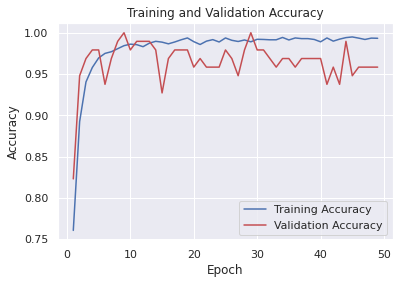

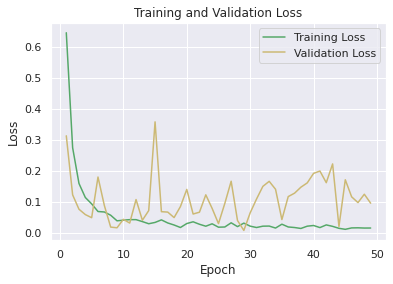

In [11]:
 #plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy =vgg_classifier.history['accuracy']
val_accuracy = vgg_classifier.history['val_accuracy']
loss = vgg_classifier.history['loss']
val_loss = vgg_classifier.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Xception Training',dpi=1000,bbox_inches='tight')

plt.figure()


#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Xception Loss',dpi=1000,bbox_inches='tight')
plt.show()
 

In [12]:
# Generate predictions
#vgg_model.load_weights('weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [13]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
 
print("Test Accuracy: {:.2f}%".format(vgg_acc * 100))

Test Accuracy: 96.03%


In [14]:
testgen.reset()
Y_pred = vgg_model.predict_generator(testgen,BATCH_SIZE)
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.9603174603174603

Confusion matrix, without normalization
[[30  1]
 [ 4 91]]


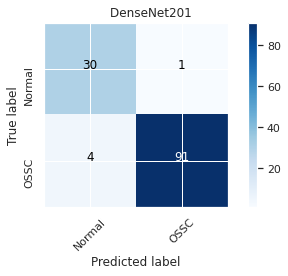

In [15]:
 

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar() 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes ,rotation=90)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(vgg_preds, axis=1))

cm_plot_label =['Normal', 'OSSC']
plot_confusion_matrix(cm, cm_plot_label, title ='        DenseNet201')
plt.savefig('Confusion Matric12',dpi=1000,bbox_inches='tight')

**ROC**

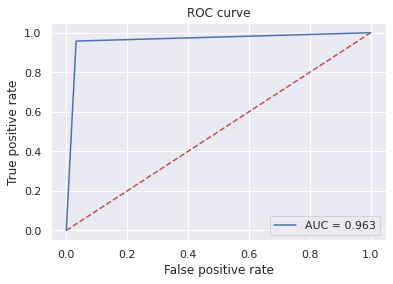

In [16]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(vgg_preds, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(vgg_preds, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC2',dpi=2000,bbox_inches='tight')
plt.show()
plt.close()

In [17]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(vgg_preds, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        31
           1       0.99      0.96      0.97        95

    accuracy                           0.96       126
   macro avg       0.94      0.96      0.95       126
weighted avg       0.96      0.96      0.96       126

